# Machine Learning Demonstrations

In this notebook, we demonstrated how to use the Kx kdb+/q Automated Machine Learning library. The example below use samples from the Wisconsin Breast Cancer Dataset dataset.

<div class="alert alert-danger">
To run the below notebook, ensure that dependencies specified in <b>requirements.txt</b> have been correctly installed.
</div>

## Machine Learning Toolkit

The Machine Learning Toolkit ([ML-Toolkit](https://github.com/KxSystems/ml)) contains general use utilities, an implementation of the FRESH (Feature Extraction based on Scalable Hypothesis tests) algorithm and cross validation functions. The primary purpose of these libraries are to provide kdb+/q users with access to commonly-used ML functions for preprocessing data, extracting features and scoring results.

## Automated Machine Learning in kdb+/q

The kdb+/q [Automated Machine Learning](... INSERT LINK HERE ...) library is built largely on the tools available within the kdb+/q ML-Toolkit. The purpose of this platform is to provide users with the ability to automate the process of applying machine learning techniques to real-world problems. In the absence of expert machine learning engineers this handles the following processes within a traditional workflow:

- Data preprocessing
- Feature engineering and feature selection
- Model selection
- Hyperparameter Tuning
- Report generation and model persistence

Each of these steps is outlined in depth within the documentation for this platform [here](... INSERT DOCUMENTATION LINK ...). This allows users to understand the processes by which decisions are being made and the transformations which their data undergo during the production of the output models.

At present the machine learning frameworks supported for this are based on:

- One-to-one feature to target non time-series
- FRESH based feature extraction and model production

The problems which can be solved by this platform will be expanded over time as will the available functionality.

The library is loaded in as follows:

In [1]:
// load in automl
\l automl/automl.q
.aml.loadfile`:init.q

/home/deanna/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/deanna/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/deanna/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/deanna/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dty

---

## Wisconsin Breast Cancer Dataset

The [Wisconsin Breast Cancer Dataset](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)) is a set of 569 samples of fine needle aspirate (FNA) of breast mass. Each sample contains features describing characteristics of the cell nuclei, along with a classification of the sample as either benign or malignant.

In each case below, we aim to create a model which can accurately dicern between the benign and malignant samples. This will be shown when pre-trained models are tested on new unseen data.

### Load data

Below we load in the data from the sklearn datasets library using embedPy. We also load in utility and graphics functions required within this notebook.

In [2]:
// load utils
\l ../utils/util.q
\l ../utils/graphics.q

In [3]:
// import data
data:.p.import[`sklearn.datasets;`:load_breast_cancer][]

// extract features and targets
feat:data[`:data]`
targ:data[`:target]`

// extract feature names
featnm:pylist[<]data`:feature_names

// inspect data
-1"Shape of feature data is: ",(" x "sv string .ml.shape feat),"\n";
show 5#feat
-1"\nDistribution of target values:\n";
show update pcnt:round[;.01]100*num%sum num from select num:count i by target from([]target:targ);

Shape of feature data is: 569 x 30

17.99 10.38 122.8 1001  0.1184  0.2776  0.3001 0.1471  0.2419 0.07871 1.095  ..
20.57 17.77 132.9 1326  0.08474 0.07864 0.0869 0.07017 0.1812 0.05667 0.5435 ..
19.69 21.25 130   1203  0.1096  0.1599  0.1974 0.1279  0.2069 0.05999 0.7456 ..
11.42 20.38 77.58 386.1 0.1425  0.2839  0.2414 0.1052  0.2597 0.09744 0.4956 ..
20.29 14.34 135.1 1297  0.1003  0.1328  0.198  0.1043  0.1809 0.05883 0.7572 ..

Distribution of target values:

target| num pcnt 
------| ---------
0     | 212 37.26
1     | 357 62.74


The original dataset is imported as a matrix. Given that automated platform only accepts features in tabular format, we must first convert the matrix into a table using the feature names imported above.

In [4]:
featnm:`${x except enlist"'"}each .p.repr each featnm
5#feat:flip featnm!flip feat

mean radius mean texture mean perimeter mean area mean smoothness mean compac..
-----------------------------------------------------------------------------..
17.99       10.38        122.8          1001      0.1184          0.2776     ..
20.57       17.77        132.9          1326      0.08474         0.07864    ..
19.69       21.25        130            1203      0.1096          0.1599     ..
11.42       20.38        77.58          386.1     0.1425          0.2839     ..
20.29       14.34        135.1          1297      0.1003          0.1328     ..


### User Interface

At the highest level the auto ml library allows for two primary callable functions:

- `.aml.run` = Run the automated machine learning pipeline on user defined data and target
- `.aml.new` = Using a previously fit model and set of instructions derived from 1 above, predict the target value for new tabular data

Both of these functions are modifiable by a user to suit specific use cases and have been designed where possible to cover a wide range of functional options and to be extensible to a users needs.

### Prepare data

As we want to run both `.aml.run` and `.aml.new` we start by splitting our data into a training and testing set, where 20% has been chosen for the testing set. Note that we have set a random seed so that results can be replicated.

In [5]:
\S 42
show inputs:.ml.traintestsplit[feat;targ;.2]

xtrain| +`mean radius`mean texture`mean perimeter`mean area`mean smoothness`m..
ytrain| 1 1 1 1 1 1 0 0 1 1 1 0 1 0 1 1 1 1 0 1 1 0 1 0 1 0 1 1 1 0 0 1 1 1 0..
xtest | +`mean radius`mean texture`mean perimeter`mean area`mean smoothness`m..
ytest | 0 0 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 0 1 1 0 0 1 1 1 0 1..


---

## Contents

Below, the notebook has been split into 2 distinct sections:
1. [Default Configurations](#Default-Configurations)
2. [Custom Configurations (Advanced)](#Custom-Configurations-(Advanced))

---

## Default Configurations

### Inputs

Below we demonstrate how to apply `.aml.run` to our features and targets in the default setting, where the function has the syntax:

```.aml.run[tab;tgt;ftype;ptype;dict]```

Where:
- `tab` is unkeyed tabular data from which the models will be created
- `tgt` is the target vector
- `ftype` type of feature extraction being completed on the dataset as a symbol (``` `fresh```/``` `normal```)
- `ptype` type of problem, regression/class, as a symbol (``` `reg```/``` `class```)
- `dict` is one of `(::)` for default behaviour, a kdb+ dictionary or path to a user defined flat file for modifying default parameters.

In this case, we select ``` `normal``` feature extraction as we have a 1-to-1 mapping between features and targets. We also use ``` `class``` for the problem type as we are dealing with a binary classification problem.

**NB:** For the purposes of this demonstration we will pass in a dictionary in place of the default parameter `(::)`. Here we alter the random seed parameter ``` `seed``` so that results can be replicated each time this notebook is run.

In [6]:
tab:inputs`xtrain             / features
tgt:inputs`ytrain             / targets
ftype:`normal                 / normal feature extraction
ptype:`class                  / classification problem
dict:enlist[`seed]!enlist 42  / default configuration

### Outputs

In the default configuration, the following items will be returned/saved during an individual run:

- The best model, saved as a hdf5 file, or "pickled" byte object.
- A saved report indicating the procedure taken and scores achieved.
- A saved binary encoded dictionary denoting the procedure to be taken for reproducing results or running on new data.
- Results from each step of the pipeline published to console.

In addition to the saved outputs, the function will also return the date and time of the current run. This allows users to run the best model from the current run on new data by passing the date and time to `.aml.new` (see example [below](#Test-on-new-data)).

We can now run `.aml.run` using the default setting with out training set from the  Wisconsin Breast Cancer dataset:

In [7]:
start:.z.t
r1:.aml.run[tab;tgt;ftype;ptype;dict]
-1"\n.aml.run took ",string .z.t-start;


The following is a breakdown of information for each of the relevant columns in the dataset

                       | count unique mean        std         min       max  ..
-----------            | ----------------------------------------------------..
mean radius            | 455   380    13.98452    3.478037    6.981     28.11..
mean texture           | 455   395    19.07686    4.297219    9.71      39.28..
mean perimeter         | 455   428    91.03527    23.99875    43.79     188.5..
mean area              | 455   436    641.0963    347.1883    143.5     2501 ..
mean smoothness        | 455   393    0.09688297  0.01444255  0.05263   0.163..
mean compactness       | 455   434    0.1049749   0.0528815   0.01938   0.345..
mean concavity         | 455   435    0.08842862  0.07988197  0         0.426..
mean concave points    | 455   434    0.04846113  0.03851485  0         0.201..
mean symmetry          | 455   357    0.1820286   0.02759591  0.1167    0.304..
mean fractal dimension | 4

/home/deanna/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
2020-01-29 17:17:21.763349: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2020-01-29 17:17:21.768873: I tensorflow/core/common_runtime/process_util.cc:69] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.



Scores for all models, using .ml.accuracy
GaussianNB                | 0.9450614
AdaBoostClassifier        | 0.9382233
GradientBoostingClassifier| 0.9381648
LogisticRegression        | 0.9313852
RandomForestClassifier    | 0.9279953
LinearSVC                 | 0.9040912
KNeighborsClassifier      | 0.8867329
MLPClassifier             | 0.6258913
SVC                       | 0.6222092
binarykeras               | 0.3777908

Best scoring model = GaussianNB
Score for validation predictions using best model = 0.9452055


Feature impact calculated for features associated with GaussianNB model
Plots saved in /outputs/2020.01.29/run_17.17.20.871/images/

Continuing to final model fitting on holdout set

Best model fitting now complete - final score on test set = 0.8901099

Saving down procedure report to /outputs/2020.01.29/run_17.17.20.871/report/
Saving down GaussianNB model to /outputs/2020.01.29/run_17.17.20.871/models/
Saving down model parameters to /outputs/2020.01.29/run_17.17.20.871/con

#### Feature impact (produced during the pipeline and saved in `images/`)

<Figure size 1440x1440 with 0 Axes>

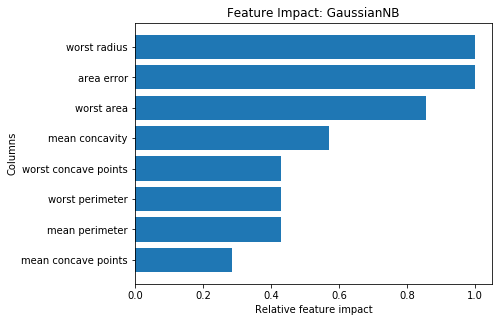

In [8]:
plt[`:show][];

We see that in the above example, 8 features were passed to the model following the application of feature extraction and significance testing. 

**NB:** In the default case, normal feature extraction will only use the original features passed in, while FRESH feature extraction will apply the functions available for FRESH within the ML-Toolkit.

Looking at the feature impact above, we can see that `worst radius` and `area error` had the highest feature impact in the dataset when applied to the best model.

We also see that expected outputs have been stored in a directory of format `/outputs/date/run_time/`

### Test on new data

We can apply the workflow and fitted model associated with our specified run to new data using:

```.aml.new[tab;dt;tm]```

Where:

- `tab` is an unkeyed tabular dataset which has the same schema as the input data from the run specified in fpath
- `dt` is the date for a specified run as a date `yyyy.mm.dd` or a string of format `"yyyy.mm.dd"`
- `tm` is the timestamp for a specified run as a timestamp `hh:mm:ss.xxx` or a string of format `"hh:mm:ss.xxx"` or `"hh.mm.ss.xxx"` 

**NB:** Outputs from previous runs, such as `models` or `config`, are stored in the `outputs` directory and are organised such that we have the following file structure: `outputs/dt/run_tm/`, e.g. `outputs/2001.01.01/run_12.00.00.000"`.

The function will return the target predictions for new data based on the previously fitted model and workflow.

Below we apply `.aml.new` to the test set we created earlier and pass in the date and time of the previous run. This will apply the best model from the previous run to our new data:

In [9]:
print_runid . r1;
-1"\nPredictions: ";
show pred:.aml.new[inputs`xtest]. r1
-1"\nTargets:";
show inputs`ytest

Run date: 2020.01.29. Run time: 17:17:20.871.

Predictions: 
0 0 1 1 0 0 1 0 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 0 1 1 0 0 1 1 1 0 1 1 0 1 0..

Targets:
0 0 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 0 1 1 0 0 1 1 1 0 1 1 0 1 0..


We can see how the model performed using `.ml.accuracy`, used in the original default pipeline, and by producing a confusion matrix using `displayCM`:

In [10]:
-1"Accuracy on model run using held-out data: ",string acc1:.ml.accuracy[inputs`ytest;pred];

Accuracy on model run using held-out data: 0.9649123


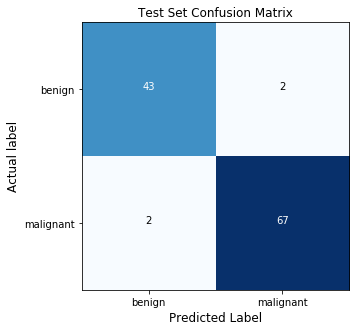

In [11]:
displayCM[value .ml.confmat[inputs`ytest;pred];`benign`malignant;"Test Set Confusion Matrix";()];

---

## Custom Configurations (Advanced)

In the previous section of the notebook, we showcased how to apply default parameters within the pipeline (excluding the random seed). In this section we will focus on how the final parameter of `.aml.run` can be modified to apply changes to the default behaviour.

There are two options for how this final parameter can be input:
- **kdb+ dictionary** outlining the changes to default behaviour that are to be made
- The path to a **flat file** containing more human readable updates to the parameter set.

### Advanced parameters

The following lists the parameters which can be altered by users to modify the functionality of the automl platform. In each case, the parameter name corresponds to the kdb+ dictionary key which would be passed, alongside its user defined value, to the `.aml.run` function in order to update functionality.

Parameters:

```txt
  aggcols     Aggregation columns for FRESH
  funcs       Functions to be applied for feature extraction
  gs          Grid search function and associated no. of folds/percentage
  hld         Size of holdout set on which the final model is tested
  saveopt     Saving options outlining what is to be saved to disk from a run
  scf         Scoring functions for classification/regression tasks
  seed        Random seed to be used
  sigfeats    Feature significance procedure to be applied to the data
  sz          Size of test set for train-test split function
  tts         Train-test split function to be applied
  xv          Cross validation function and associated no. of folds/percentage
```

### Example 1

In this case, we have altered the parameter dictionary `p` in the following ways:
- Added a **random seed**: Here we have altered the ``` `seed``` parameter to be `42`, the same as the example above.
- Changed the **scoring function**: In this case we use the MSE as the scoring metric, creating a dictionary for ``` `scf``` which sets the classification scoring function to `.ml.mse`.
- Added functions to apply during normal **feature extraction**: As mentioned above, in the default setting no functions are applied to the table during feature extraction. Below we apply `.aml.prep.i.truncsvd` and `.aml.prep.i.bulktransform` to the data.

In [12]:
show p:`seed`scf`funcs!(42;enlist[`class]!enlist`.ml.mse;`.aml.prep.i.truncsvd`.aml.prep.i.bulktransform)

seed | 42
scf  | (,`class)!,`.ml.mse
funcs| `.aml.prep.i.truncsvd`.aml.prep.i.bulktransform


In [13]:
r2:.aml.run[inputs`xtrain;inputs`ytrain;`normal;`class;p]


The following is a breakdown of information for each of the relevant columns in the dataset

                       | count unique mean        std         min       max  ..
-----------            | ----------------------------------------------------..
mean radius            | 455   380    13.98452    3.478037    6.981     28.11..
mean texture           | 455   395    19.07686    4.297219    9.71      39.28..
mean perimeter         | 455   428    91.03527    23.99875    43.79     188.5..
mean area              | 455   436    641.0963    347.1883    143.5     2501 ..
mean smoothness        | 455   393    0.09688297  0.01444255  0.05263   0.163..
mean compactness       | 455   434    0.1049749   0.0528815   0.01938   0.345..
mean concavity         | 455   435    0.08842862  0.07988197  0         0.426..
mean concave points    | 455   434    0.04846113  0.03851485  0         0.201..
mean symmetry          | 455   357    0.1820286   0.02759591  0.1167    0.304..
mean fractal dimension | 4

#### Feature impact (produced during the pipeline and saved in `images/`)

<Figure size 1440x1440 with 0 Axes>

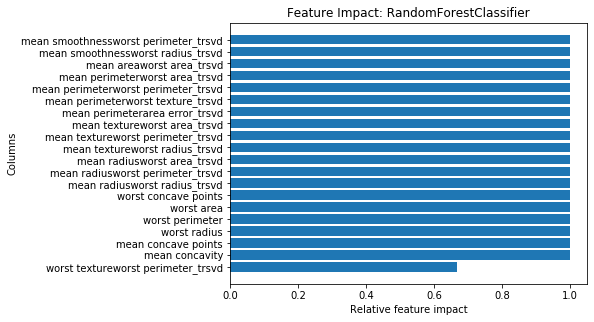

In [14]:
plt[`:show][];

We can see in the above output that our specified changes have been applied, where the scoring function has been changed to `.ml.mse` and scores are now in ascending order as a result. Additionally, applying our specified feature extraction functions resulted in 116 features being passed to the models, with the feature impact highlighting the importance of applying truncated SVD to the original data.

We can now predict on the held-out data and compare accuracy results to the default case.

In [15]:
print_runid . r2;
-1"\nPredictions: ";
show pred:.aml.new[inputs`xtest]. r2
-1"\nTargets:";
show inputs`ytest

Run date: 2020.01.29. Run time: 17:17:24.063.

Predictions: 
0 0 1 1 0 0 1 0 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 0 1 1 0 0 1 1 1 0 1 1 0 1 0..

Targets:
0 0 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 0 1 1 0 0 1 1 1 0 1 1 0 1 0..


In [16]:
print_runid . r1;
-1"Accuracy on default model run using held-out data: ",string[acc1],"\n";
print_runid . r2;
-1"Accuracy on custom model run using held-out data : ",string .ml.accuracy[inputs`ytest;pred];

Run date: 2020.01.29. Run time: 17:17:20.871.
Accuracy on default model run using held-out data: 0.9649123

Run date: 2020.01.29. Run time: 17:17:24.063.
Accuracy on custom model run using held-out data : 0.9912281


We can see that by adding feature extraction in the normal case we have improved our accuracy. This is highlighted in the confusion matrix below.

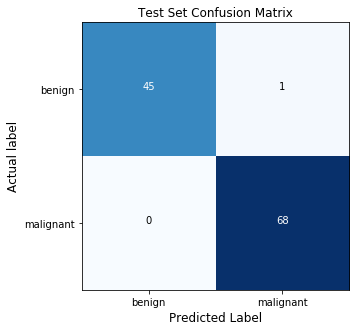

In [17]:
displayCM[value .ml.confmat[inputs`ytest;pred];`benign`malignant;"Test Set Confusion Matrix";()];

### Example 2

In this example we highlight how to change the save options, contained under ``` `saveopt``` within the parameter dictionary.

In the default case, used in both examples above, the system will save all outputs to disk (reports, images, config file and models). This can be altered by the user to reduce the number of outputs saved to disk, where:

- `0` = Nothing is saved the models will run and display results to console but nothing persisted
- `1` = Save the model and configuration file only, will not generate a report for the user or any images
- `2` = Save all possible outputs to disk for the user including reports, images, config and models

We demonstrate the case for `0` below.

In [18]:
.aml.run[inputs`xtrain;inputs`ytrain;`normal;`class;enlist[`saveopt]!enlist 0];


The following is a breakdown of information for each of the relevant columns in the dataset

                       | count unique mean        std         min       max  ..
-----------            | ----------------------------------------------------..
mean radius            | 455   380    13.98452    3.478037    6.981     28.11..
mean texture           | 455   395    19.07686    4.297219    9.71      39.28..
mean perimeter         | 455   428    91.03527    23.99875    43.79     188.5..
mean area              | 455   436    641.0963    347.1883    143.5     2501 ..
mean smoothness        | 455   393    0.09688297  0.01444255  0.05263   0.163..
mean compactness       | 455   434    0.1049749   0.0528815   0.01938   0.345..
mean concavity         | 455   435    0.08842862  0.07988197  0         0.426..
mean concave points    | 455   434    0.04846113  0.03851485  0         0.201..
mean symmetry          | 455   357    0.1820286   0.02759591  0.1167    0.304..
mean fractal dimension | 4

We see that nothing has been saved down during a single run of the pipeline.

### Example 3

We have shown in the previous examples that the pipeline can be altered by passing in a dictionary of parameters as the last argument in `.aml.run`. As mentioned above, we can also pass the path to a flat file.

Default flat files are contained within `automl/code/models/` where users can change parameters within each file. If these files have been changed from the default setting and a user wishes to re-save the original, we can do so using the following:

In [19]:
.aml.savedefault["new_normal_defaults.txt";`normal]

We can then run the pipeline using this new file as our final argument:

In [20]:
.aml.run[inputs`xtrain;inputs`ytrain;`normal;`class;"new_normal_defaults.txt"];


The following is a breakdown of information for each of the relevant columns in the dataset

                       | count unique mean        std         min       max  ..
-----------            | ----------------------------------------------------..
mean radius            | 455   380    13.98452    3.478037    6.981     28.11..
mean texture           | 455   395    19.07686    4.297219    9.71      39.28..
mean perimeter         | 455   428    91.03527    23.99875    43.79     188.5..
mean area              | 455   436    641.0963    347.1883    143.5     2501 ..
mean smoothness        | 455   393    0.09688297  0.01444255  0.05263   0.163..
mean compactness       | 455   434    0.1049749   0.0528815   0.01938   0.345..
mean concavity         | 455   435    0.08842862  0.07988197  0         0.426..
mean concave points    | 455   434    0.04846113  0.03851485  0         0.201..
mean symmetry          | 455   357    0.1820286   0.02759591  0.1167    0.304..
mean fractal dimension | 4

---